This script shows the full training and prediction pipeline for a pixel-based classifier: we create a mask, train logistic regression on one-pixel patches, make prediction for all pixels, create and smooth polygons from pixels.

In [1]:
from collections import defaultdict
import csv
import sys

import cv2
from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt
import shapely.affinity
import numpy as np
import tifffile as tiff

csv.field_size_limit(sys.maxsize);

We'll work on buildings (class 1) from image 6120_2_2. Fist load grid sizes and polygons.

In [2]:
IM_ID = '6120_2_2'
POLY_TYPE = '1'  # buildings

# Load grid size
x_max = y_min = None
for _im_id, _x, _y in csv.reader(open('../input/grid_sizes.csv')):
    if _im_id == IM_ID:
        x_max, y_min = float(_x), float(_y)
        break

# Load train poly with shapely
train_polygons = None
for _im_id, _poly_type, _poly in csv.reader(open('../input/train_wkt_v4.csv')):
    if _im_id == IM_ID and _poly_type == POLY_TYPE:
        train_polygons = shapely.wkt.loads(_poly)
        break

# Read image with tiff
im_rgb = tiff.imread('../input/three_band/{}.tif'.format(IM_ID)).transpose([1, 2, 0])
im_size = im_rgb.shape[:2]

Scale polygons to match image:

In [3]:
def get_scalers():
    h, w = im_size  # they are flipped so that mask_for_polygons works correctly
    w_ = w * (w / (w + 1))
    h_ = h * (h / (h + 1))
    return w_ / x_max, h_ / y_min

x_scaler, y_scaler = get_scalers()

train_polygons_scaled = shapely.affinity.scale(
    train_polygons, xfact=x_scaler, yfact=y_scaler, origin=(0, 0, 0))

Create a mask from polygons:

In [4]:
def mask_for_polygons(polygons):
    img_mask = np.zeros(im_size, np.uint8)
    if not polygons:
        return img_mask
    int_coords = lambda x: np.array(x).round().astype(np.int32)
    exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
    interiors = [int_coords(pi.coords) for poly in polygons
                 for pi in poly.interiors]
    cv2.fillPoly(img_mask, exteriors, 1)
    cv2.fillPoly(img_mask, interiors, 0)
    return img_mask

train_mask = mask_for_polygons(train_polygons_scaled)

A helper for nicer display

In [5]:
def scale_percentile(matrix):
    w, h, d = matrix.shape
    matrix = np.reshape(matrix, [w * h, d]).astype(np.float64)
    # Get 2nd and 98th percentile
    mins = np.percentile(matrix, 1, axis=0)
    maxs = np.percentile(matrix, 99, axis=0) - mins
    matrix = (matrix - mins[None, :]) / maxs[None, :]
    matrix = np.reshape(matrix, [w, h, d])
    matrix = matrix.clip(0, 1)
    return matrix

Check that image and mask are aligned.
Image:

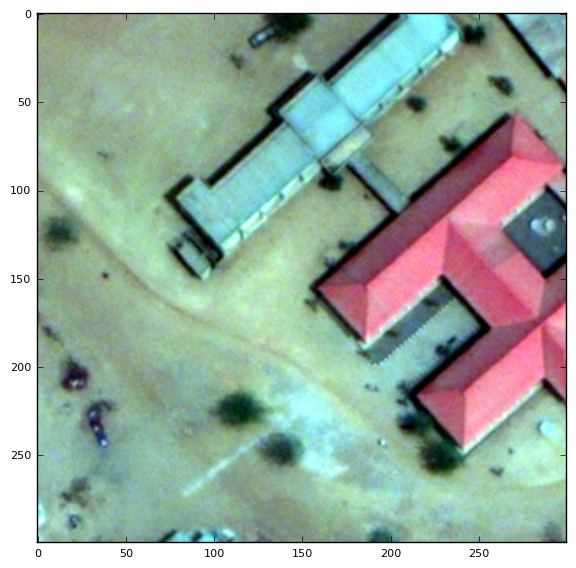

In [6]:
tiff.imshow(255 * scale_percentile(im_rgb[2900:3200,2000:2300]));

And mask:

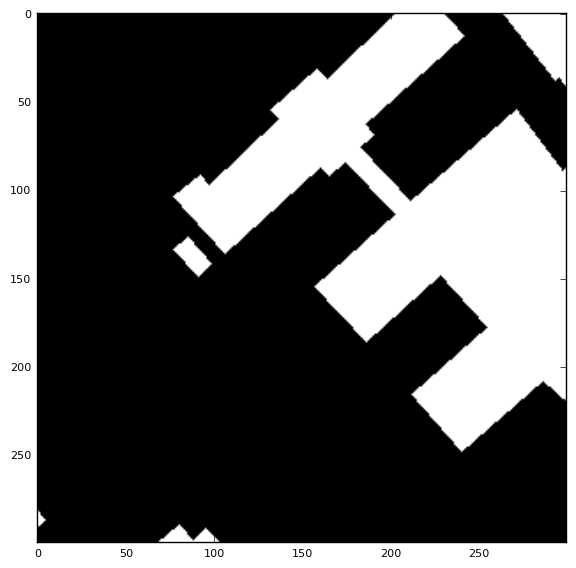

In [7]:
def show_mask(m):
    # hack for nice display
    tiff.imshow(255 * np.stack([m, m, m]));
show_mask(train_mask[2900:3200,2000:2300])

Now, let's train a very simple logistic regression classifier, just to get some noisy prediction to show how output mask is processed.

In [8]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import average_precision_score

xs = im_rgb.reshape(-1, 3).astype(np.float32)
ys = train_mask.reshape(-1)
pipeline = make_pipeline(StandardScaler(), SGDClassifier(loss='log'))

print('training...')
# do not care about overfitting here
pipeline.fit(xs, ys)
pred_ys = pipeline.predict_proba(xs)[:, 1]
print('average precision', average_precision_score(ys, pred_ys))
pred_mask = pred_ys.reshape(train_mask.shape)

training...
average precision 0.832469626588


Now check predictions:

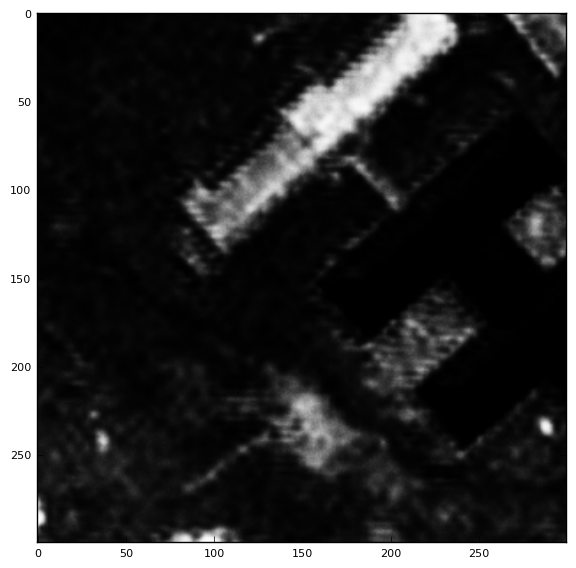

In [9]:
show_mask(pred_mask[2900:3200,2000:2300])

We must choose a threshold to turn it into a binary mask:

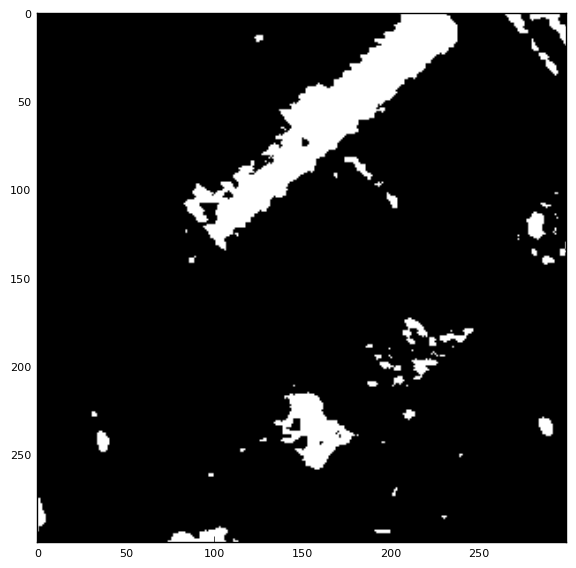

In [10]:
threshold = 0.3
pred_binary_mask = pred_mask >= threshold
show_mask(pred_binary_mask[2900:3200,2000:2300])

Now it's possible to check Jaccard on the pixel level:

In [11]:
# check jaccard on the pixel level
tp, fp, fn = (( pred_binary_mask &  train_mask).sum(),
              ( pred_binary_mask & ~train_mask).sum(),
              (~pred_binary_mask &  train_mask).sum())
print('Pixel jaccard', tp / (tp + fp + fn))

Pixel jaccard 0.605264912684


Next is the most interesting bit, creating polygons from bit masks. Please see inline comments:

In [12]:
def mask_to_polygons(mask, epsilon=10., min_area=10.):
    # first, find contours with cv2: it's much faster than shapely
    image, contours, hierarchy = cv2.findContours(
        ((mask == 1) * 255).astype(np.uint8),
        cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)
    # create approximate contours to have reasonable submission size
    approx_contours = [cv2.approxPolyDP(cnt, epsilon, True)
                       for cnt in contours]
    if not contours:
        return MultiPolygon()
    # now messy stuff to associate parent and child contours
    cnt_children = defaultdict(list)
    child_contours = set()
    assert hierarchy.shape[0] == 1
    # http://docs.opencv.org/3.1.0/d9/d8b/tutorial_py_contours_hierarchy.html
    for idx, (_, _, _, parent_idx) in enumerate(hierarchy[0]):
        if parent_idx != -1:
            child_contours.add(idx)
            cnt_children[parent_idx].append(approx_contours[idx])
    # create actual polygons filtering by area (removes artifacts)
    all_polygons = []
    for idx, cnt in enumerate(approx_contours):
        if idx not in child_contours and cv2.contourArea(cnt) >= min_area:
            assert cnt.shape[1] == 1
            poly = Polygon(
                shell=cnt[:, 0, :],
                holes=[c[:, 0, :] for c in cnt_children.get(idx, [])
                       if cv2.contourArea(c) >= min_area])
            all_polygons.append(poly)
    # approximating polygons might have created invalid ones, fix them
    all_polygons = MultiPolygon(all_polygons)
    if not all_polygons.is_valid:
        all_polygons = all_polygons.buffer(0)
        # Sometimes buffer() converts a simple Multipolygon to just a Polygon,
        # need to keep it a Multi throughout
        if all_polygons.type == 'Polygon':
            all_polygons = MultiPolygon([all_polygons])
    return all_polygons

Turn our prediction to polygons, and then turn back into a mask to check what it looks like:

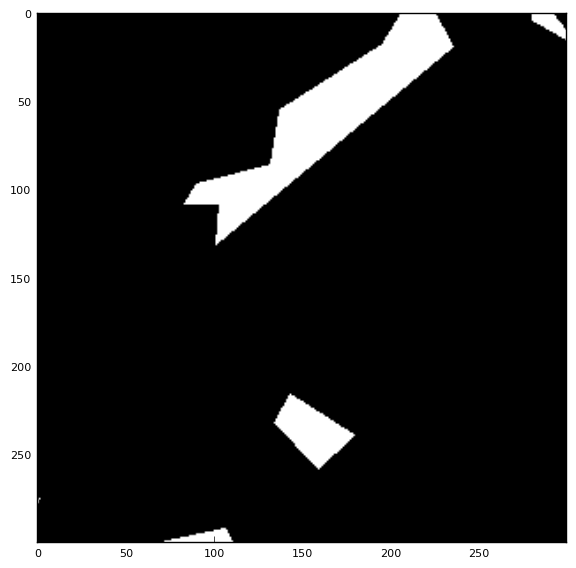

In [13]:
pred_polygons = mask_to_polygons(pred_binary_mask)
pred_poly_mask = mask_for_polygons(pred_polygons)
show_mask(pred_poly_mask[2900:3200,2000:2300])

Now to create a submission we just scale back to original coordinates

In [14]:
scaled_pred_polygons = shapely.affinity.scale(
    pred_polygons, xfact=1 / x_scaler, yfact=1 / y_scaler, origin=(0, 0, 0))

Checking submission size:

In [15]:
dumped_prediction = shapely.wkt.dumps(scaled_pred_polygons)
print('Prediction size: {:,} bytes'.format(len(dumped_prediction)))
final_polygons = shapely.wkt.loads(dumped_prediction)

Prediction size: 350,844 bytes


Now the litmus test: check Jaccard compared to **original** polygons


In [16]:
print('Final jaccard',
      final_polygons.intersection(train_polygons).area /
      final_polygons.union(train_polygons).area)

Final jaccard 0.5513262117819965
